In [2]:
# import os
# os.environ["PINECONE_API_KEY"]
# from dotenv import load_dotenv
# load_dotenv()

In [3]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import TextFileToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
# from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
# from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack_integrations.document_stores.pinecone import PineconeDocumentStore
# from haystack import Document
# from cohere_haystack.embedders.document_embedder import CohereDocumentEmbedder
from haystack_integrations.components.embedders.cohere.document_embedder import CohereDocumentEmbedder
# Make sure you have the PINECONE_API_KEY environment variable set
document_store = PineconeDocumentStore(
  index="prototype",
  metric="cosine",
  dimension=384,
  spec={"serverless": {"region": "us-east-1", "cloud": "aws"}},
  )

# document_store = InMemoryDocumentStore()
file_type_router = FileTypeRouter(mime_types=["text/plain"])
text_file_converter = TextFileToDocument()
document_joiner = DocumentJoiner()


/Users/bobbybidon/git/rag-advisor/.conda/lib/python3.11/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=150, split_overlap=50)

In [5]:
# document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
# document_embedder = CohereDocumentEmbedder(api_key=Secret.from_token("<your-api-key>"))
# document_embedder = CohereDocumentEmbedder(model="embed-multilingual-v3.0", input_type="search_document")
document_embedder = CohereDocumentEmbedder(model="embed-multilingual-light-v3.0", input_type="search_document")
document_writer = DocumentWriter(document_store)

In [6]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=text_file_converter, name="text_file_converter")
preprocessing_pipeline.add_component(instance=document_joiner, name="document_joiner")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")


In [7]:
preprocessing_pipeline.connect("file_type_router.text/plain", "text_file_converter.sources")
preprocessing_pipeline.connect("text_file_converter", "document_joiner")
preprocessing_pipeline.connect("document_joiner", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")


🚅 Components
  - file_type_router: FileTypeRouter
  - text_file_converter: TextFileToDocument
  - document_joiner: DocumentJoiner
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: CohereDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.text/plain -> text_file_converter.sources (List[Path])
  - text_file_converter.documents -> document_joiner.documents (List[Document])
  - document_joiner.documents -> document_cleaner.documents (List[Document])
  - document_cleaner.documents -> document_splitter.documents (List[Document])
  - document_splitter.documents -> document_embedder.documents (List[Document])
  - document_embedder.documents -> document_writer.documents (List[Document])

In [8]:
from pathlib import Path

output_dir = "../data/text"
preprocessing_pipeline.run({"file_type_router": {"sources": list(Path(output_dir).glob("**/*"))}})


Calculating embeddings: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]
Document 980627116e6ba84e9b93ef300b8fa002c1a6bfe7e6982f6d98e257b74ecf5151 has metadata fields with unsupported types: ['_split_overlap']. Only str, int, bool, and List[str] are supported. The values of these fields will be discarded.
Document 72544a799ea29f19fa0d2951bd47070da012fa32937a459d031236a2188b6830 has metadata fields with unsupported types: ['_split_overlap']. Only str, int, bool, and List[str] are supported. The values of these fields will be discarded.
Document 5c14304b023d72f29decf794b1cb95280b896f61cc956aaebe0903e0bcff3080 has metadata fields with unsupported types: ['_split_overlap']. Only str, int, bool, and List[str] are supported. The values of these fields will be discarded.
Document 46e1099553ef8047359835f691e45caba3ef6d2a8fb46a90c604cc194b6a8b4e has metadata fields with unsupported types: ['_split_overlap']. Only str, int, bool, and List[str] are supported. The values of these fields will be disca

{'document_embedder': {'meta': ApiMeta(api_version=ApiMetaApiVersion(version='1', is_deprecated=None, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=665.0, output_tokens=None, search_units=None, classifications=None), tokens=None, warnings=[])},
 'document_writer': {'documents_written': 35}}

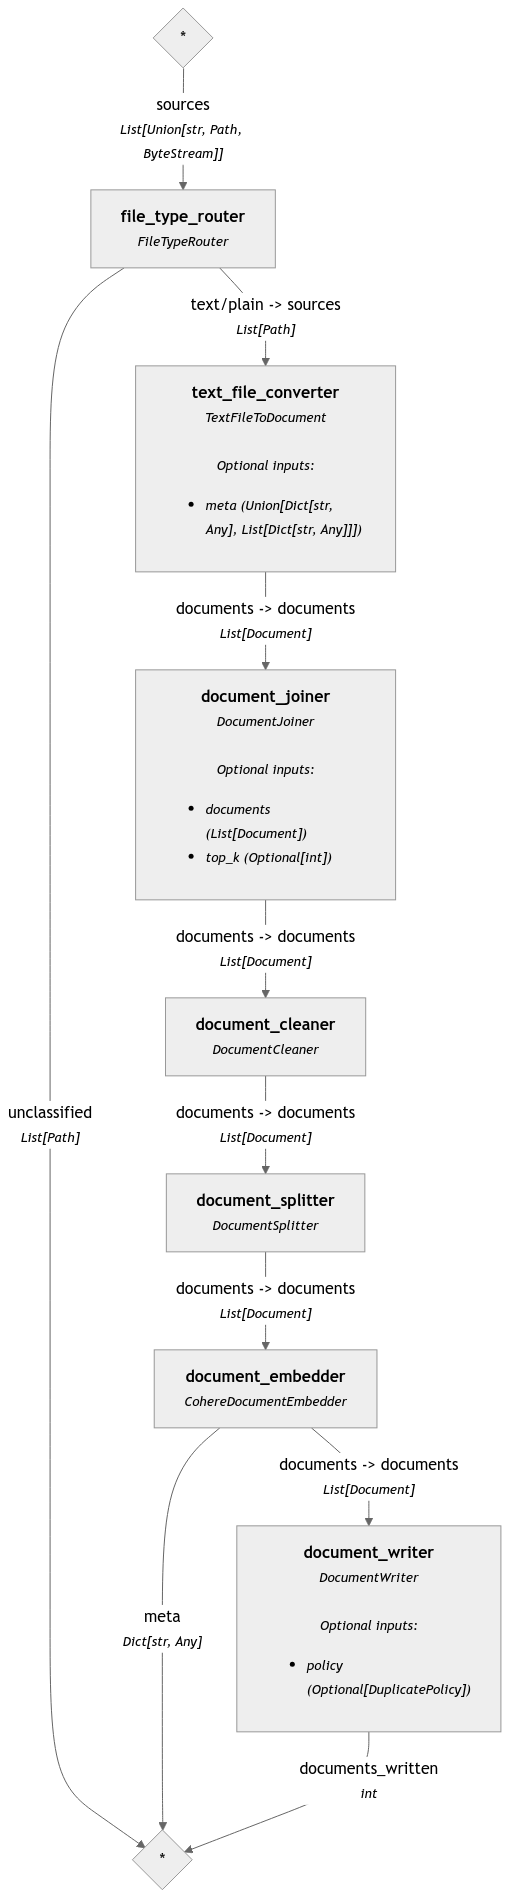

In [9]:
preprocessing_pipeline.show()